# Extra
###  I tried the same rocket problem but with drag being present in x,y,x all directions. Assuming drag to be 1 in x & z direction whereas 0.02 in y direction due to a conic shape.

## Problem formulation

### Objective Function
$$
\begin{aligned}
\quad\min_{\theta} ||s(T)||^2
\end{aligned}
$$
where,$$
\begin{aligned}
\quad s(T) = (X(T), V_x(T), Y(T), V_y(T), Z(T), V_z(T))
\end{aligned}
$$

### Constraints

$$
\quad  X(t+1) = X(t) + V_x(t) \Delta t,
\quad  V_x(t+1) = V_x(t) + a_x(t) \Delta t,
\quad  Y(t+1) = Y(t) + V_y(t) \Delta t,
\quad  V_y(t+1) = V_y(t) + a_y(t) \Delta t - a_ydrag(t) \Delta t,
\quad  Z(t+1) = Z(t) + V_z(t) \Delta t,
\quad  V_z(t+1) = V_z(t) + a_z(t) \Delta t,
\quad  a_y(t), a_x(t), a_z(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
$$

In [1]:
#Importing Libraries

import logging
from math import *
import random as r
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [2]:
#Environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81  # gravity
BOOST_ACCEL = 12  # thrust is taken constant 12 m/s^2

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action[0] = Thrust in x
        action[1] = Thrust in y
        action[2] = Thrust in z
        state[0] = x
        state[1] = x_dot
        state[2] = y
        state[3] = y_dot
        state[4] = z
        state[5] = z_dot
        
        """

        #Gravity
        delta_stateg = t.tensor([0., 0., 0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])

        #Thrust in x,y,z
        delta_statex = t.tensor([0., -BOOST_ACCEL * FRAME_TIME, 0., 0., 0., 0.]) * action[0]

        delta_statey = t.tensor([0., 0., 0., -BOOST_ACCEL * FRAME_TIME, 0., 0.]) * action[1]

        delta_statez = t.tensor([0., 0., 0., 0., 0., -BOOST_ACCEL * FRAME_TIME]) * action[2]

        #Updating drag
        DRAG_DECELx = 1 * delta_statex* delta_statex
        DRAG_DECELy = 0.002 * delta_statey* delta_statey
        DRAG_DECELz = 1 * delta_statez* delta_statez

        #New Thrust in x,y,z
        delta_statex = (BOOST_ACCEL - DRAG_DECELx) * FRAME_TIME * t.tensor([0., -1., 0., 0., 0., 0.]) * action[0]
        delta_statey = (BOOST_ACCEL - DRAG_DECELy) * FRAME_TIME * t.tensor([0., 0., 0., -1., 0., 0.]) * action[1]
        delta_statez = (BOOST_ACCEL - DRAG_DECELz) * FRAME_TIME * t.tensor([0., 0., 0., 0., 0., -1.]) * action[2]

        # Update velocity
        state = state + delta_stateg + delta_statex  + delta_statey + delta_statez

        # Update state
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., FRAME_TIME, 0., 0.],
                            [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME],[0., 0., 0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [3]:
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1.5, 0., 4., 0., 1.5, 0.]  #Initial states
        return t.tensor(state, requires_grad=False).float()

    #Error
    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2 + state[4]**2 + state[5]**2

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('_______________________________________________________________________________________________________________')
            print('\nIteration number:\t',epoch+1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        a = data[:, 2]
        b = data[:, 3]
        p = data[:, 4]
        q = data[:, 5]

        plt.figure()
        plt.subplot(221)
        plt.title('X Distance vs X Velocity')
        plt.xlabel('X Distance')
        plt.ylabel('X Velocity')
        plt.plot(x, y)

        plt.subplot(222)
        plt.title('Y Distance vs Y Velocity')
        plt.xlabel('Y Distance')
        plt.ylabel('Y Velocity')
        plt.plot(a, b)
        plt.tight_layout()
        plt.show()

        plt.subplot(223)
        plt.title('Z Distance vs Z Velocity')
        plt.xlabel('Z Distance')
        plt.ylabel('Z Velocity')
        plt.plot(p, q)
        plt.tight_layout()
        plt.show()
        
        fig = plt.figure()
        plt.title('Trajectory')
        ax = plt.axes(projection='3d')
        ax.plot3D(q, y, b, 'gray')

_______________________________________________________________________________________________________________

Iteration number:	 1
loss: 75932.141


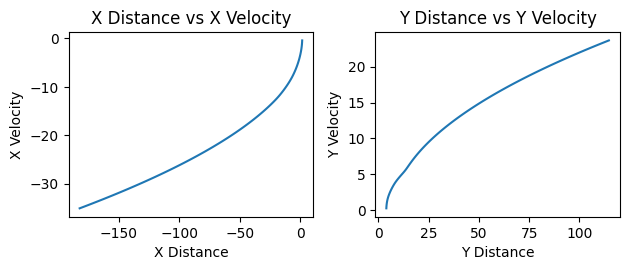

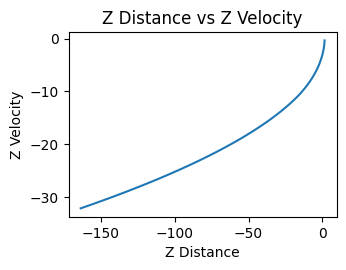

_______________________________________________________________________________________________________________

Iteration number:	 2
loss: 24551.180


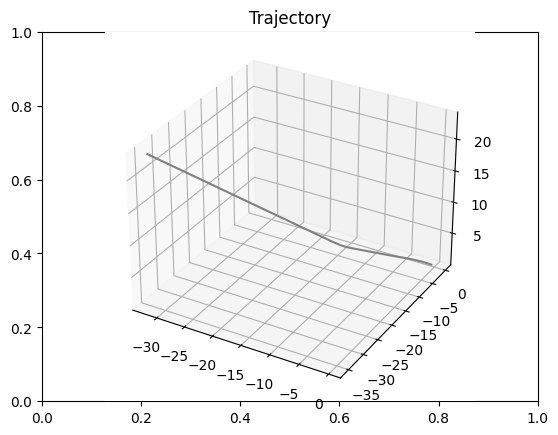

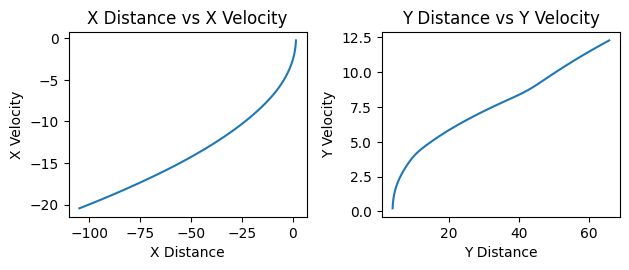

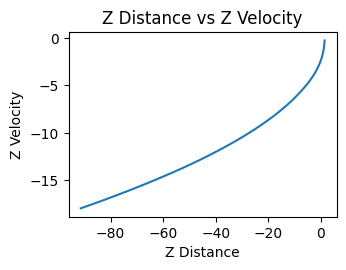

_______________________________________________________________________________________________________________

Iteration number:	 3
loss: 14497.201


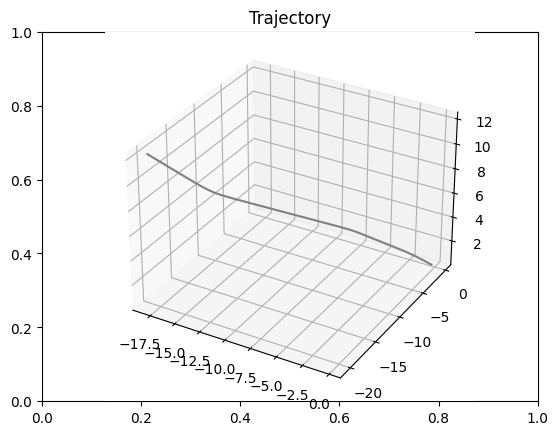

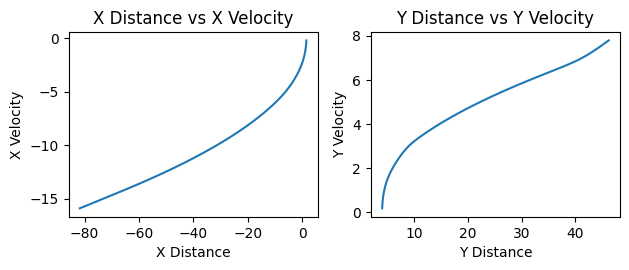

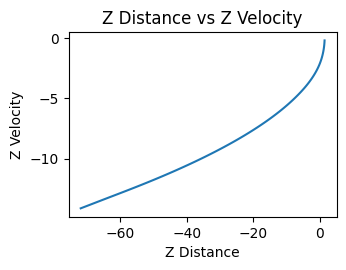

_______________________________________________________________________________________________________________

Iteration number:	 4
loss: 9260.365


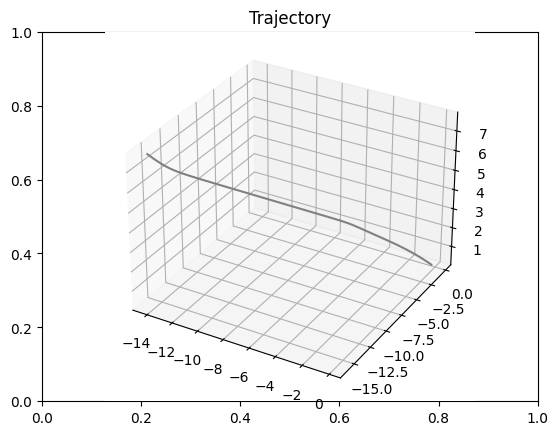

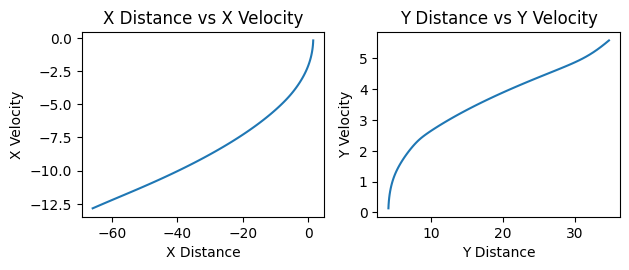

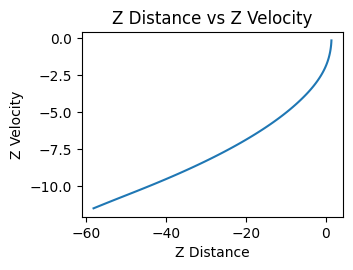

_______________________________________________________________________________________________________________

Iteration number:	 5
loss: 6376.943


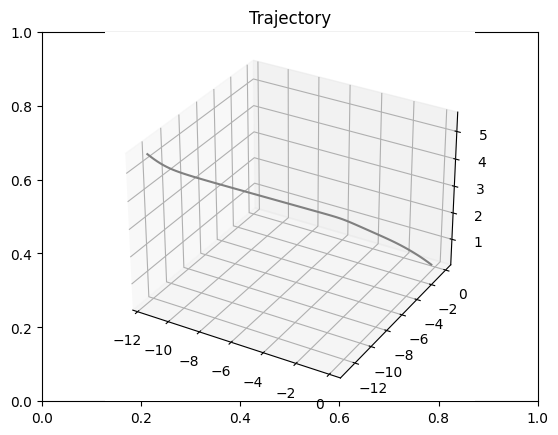

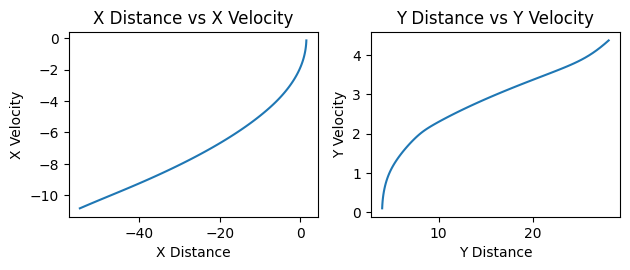

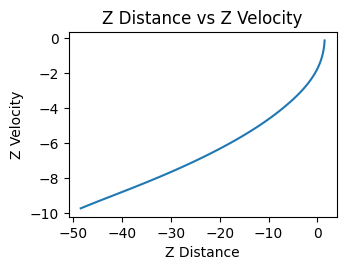

_______________________________________________________________________________________________________________

Iteration number:	 6
loss: 3741.549


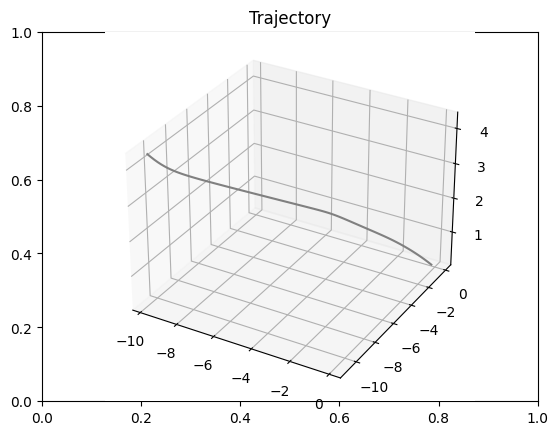

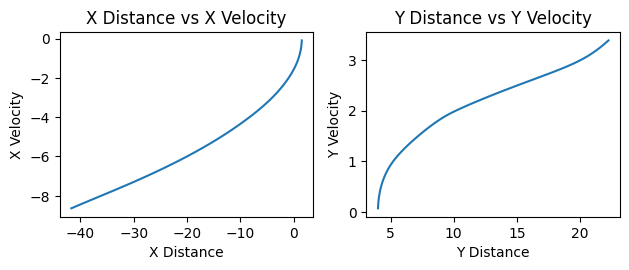

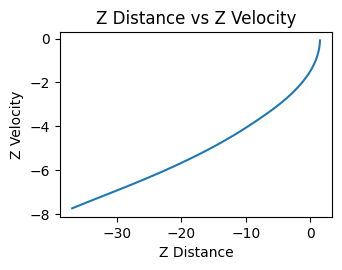

_______________________________________________________________________________________________________________

Iteration number:	 7
loss: 2006.306


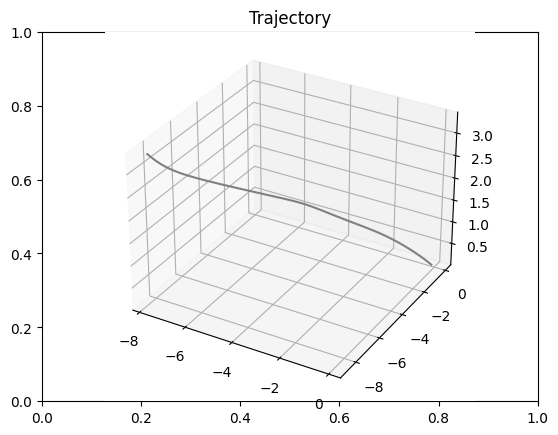

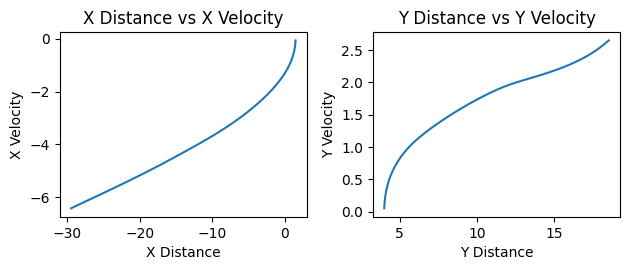

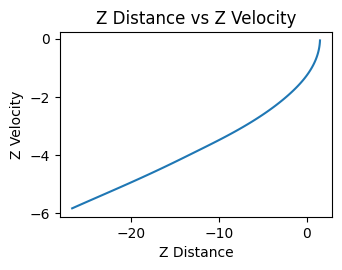

_______________________________________________________________________________________________________________

Iteration number:	 8
loss: 1498.571


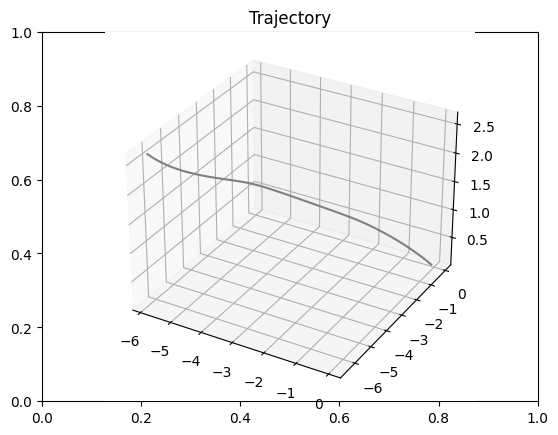

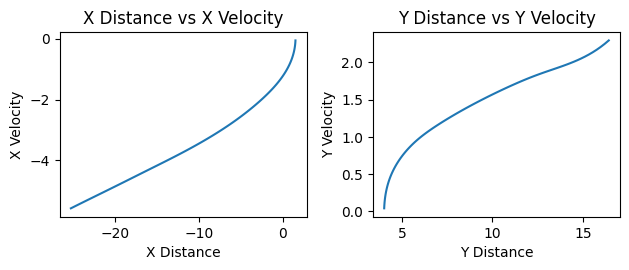

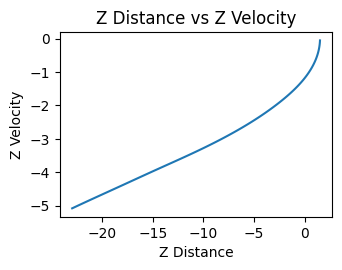

_______________________________________________________________________________________________________________

Iteration number:	 9
loss: 874.292


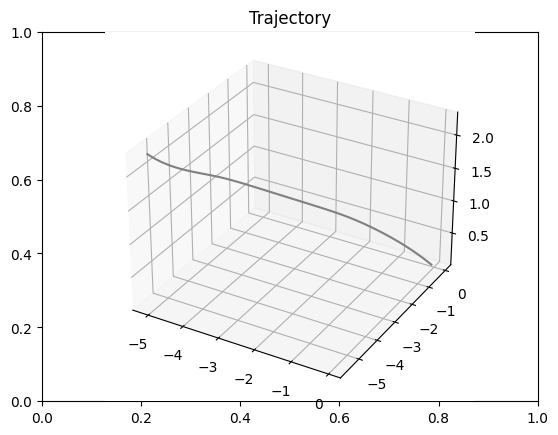

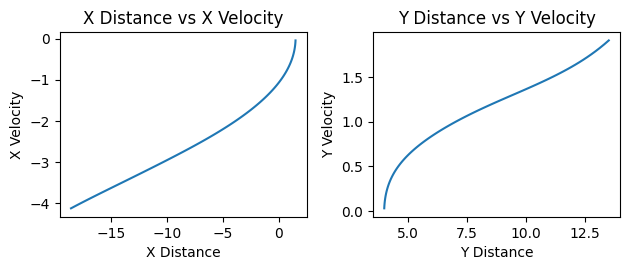

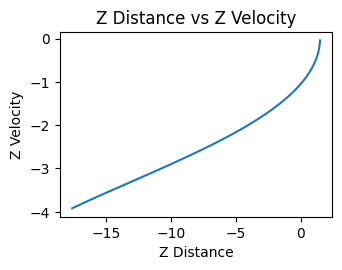

_______________________________________________________________________________________________________________

Iteration number:	 10
loss: 689.895


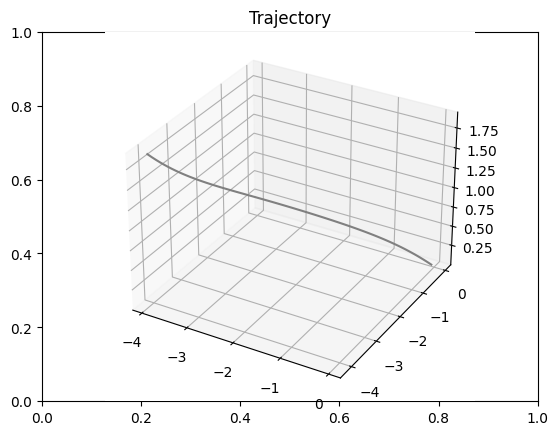

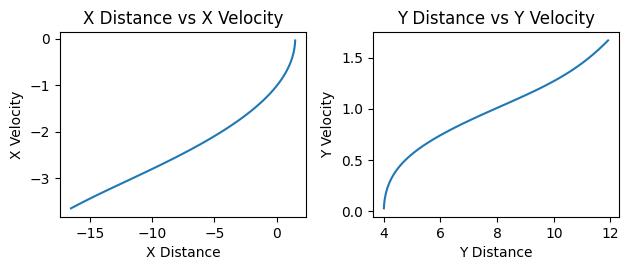

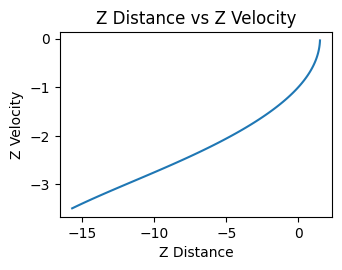

_______________________________________________________________________________________________________________

Iteration number:	 11
loss: 545.398


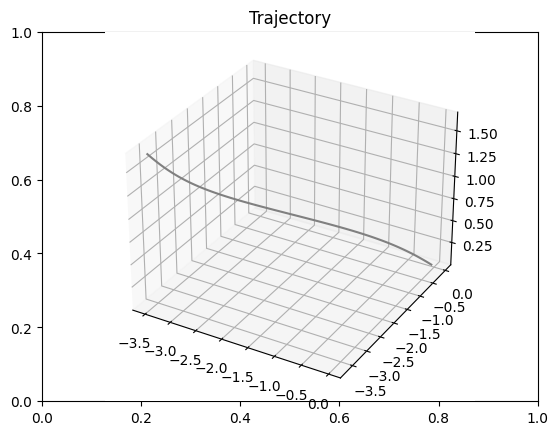

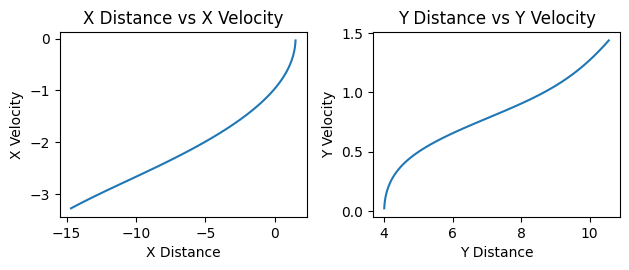

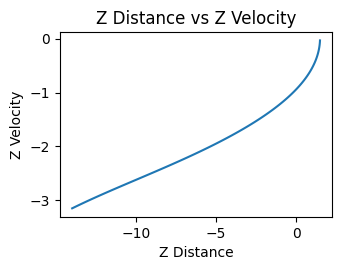

_______________________________________________________________________________________________________________

Iteration number:	 12
loss: 398.430


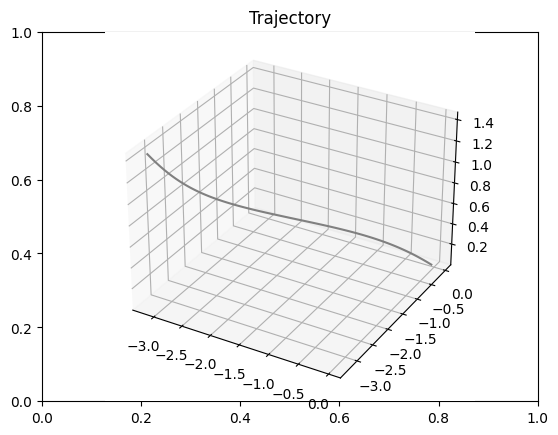

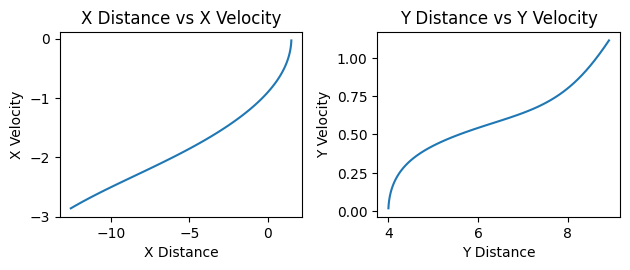

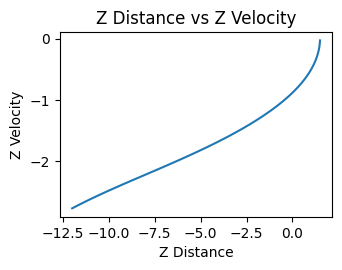

_______________________________________________________________________________________________________________

Iteration number:	 13
loss: 274.123


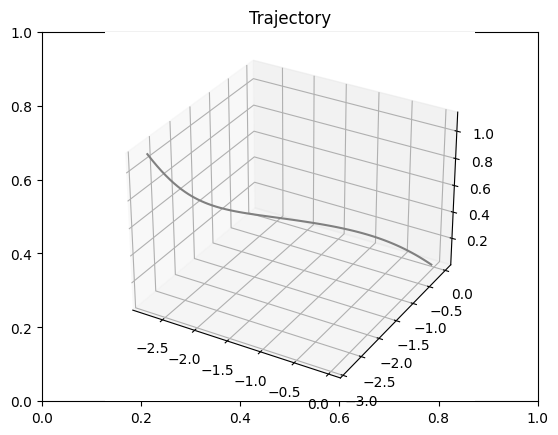

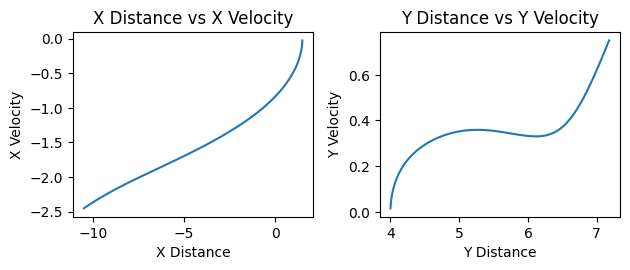

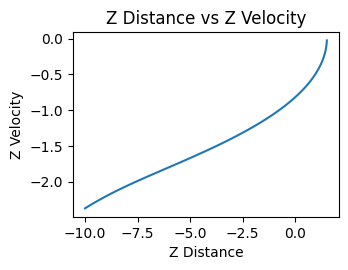

_______________________________________________________________________________________________________________

Iteration number:	 14
loss: 175.549


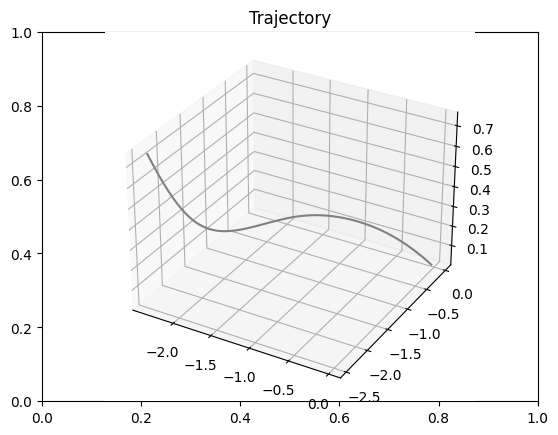

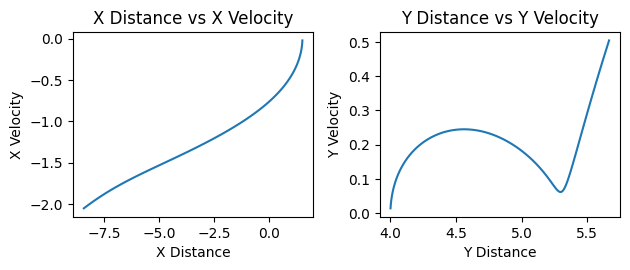

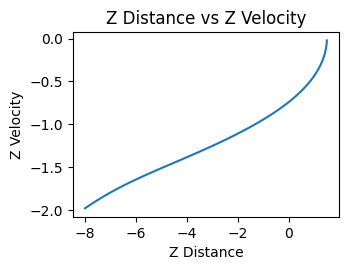

_______________________________________________________________________________________________________________

Iteration number:	 15
loss: 118.824


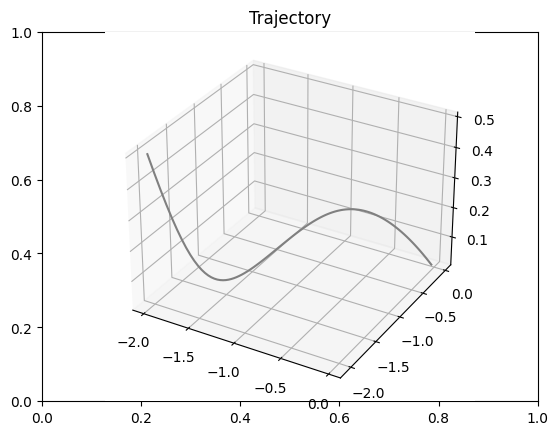

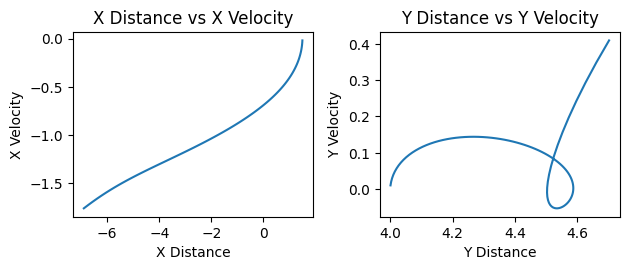

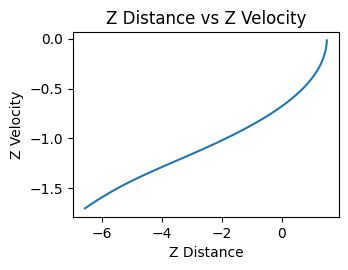

_______________________________________________________________________________________________________________

Iteration number:	 16
loss: 89.583


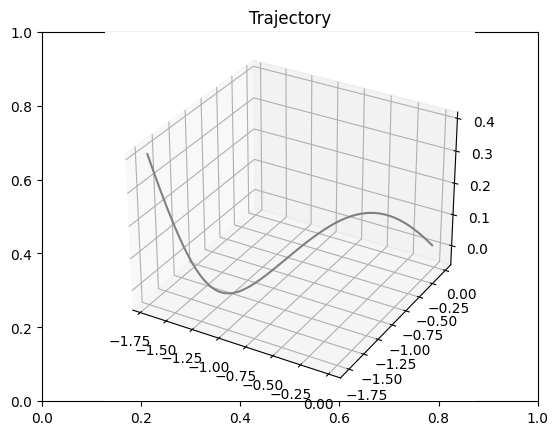

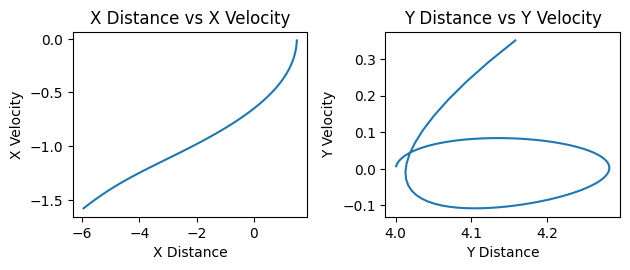

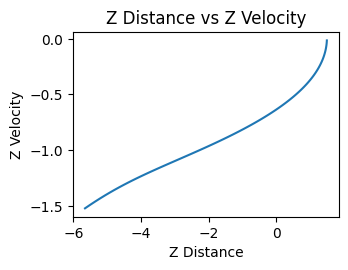

_______________________________________________________________________________________________________________

Iteration number:	 17
loss: 68.035


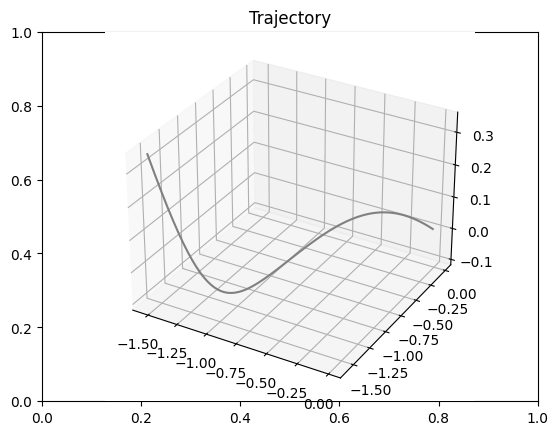

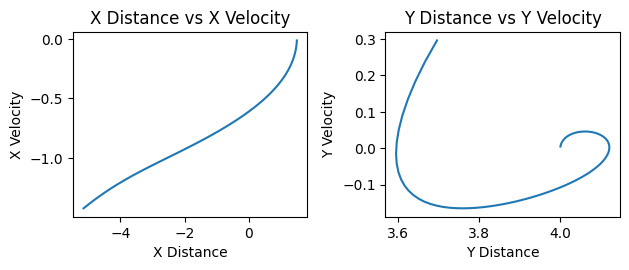

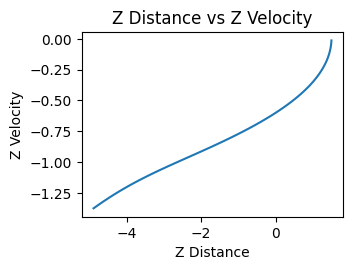

_______________________________________________________________________________________________________________

Iteration number:	 18
loss: 50.945


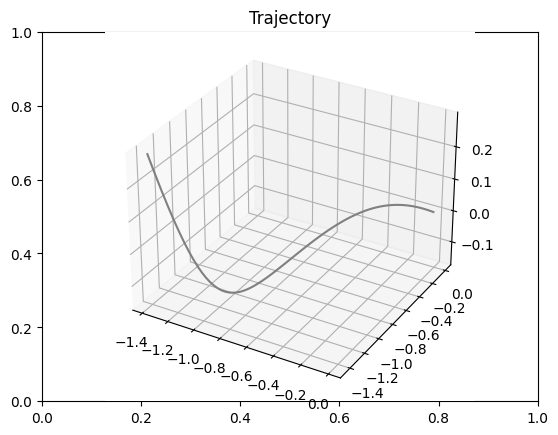

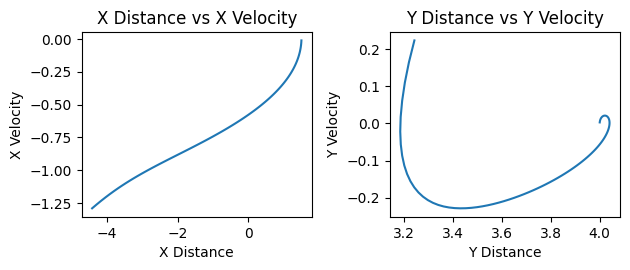

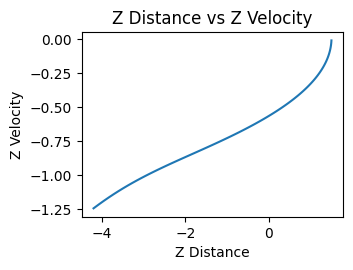

_______________________________________________________________________________________________________________

Iteration number:	 19
loss: 37.907


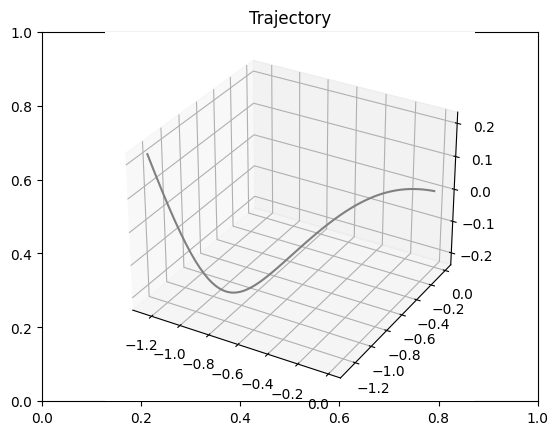

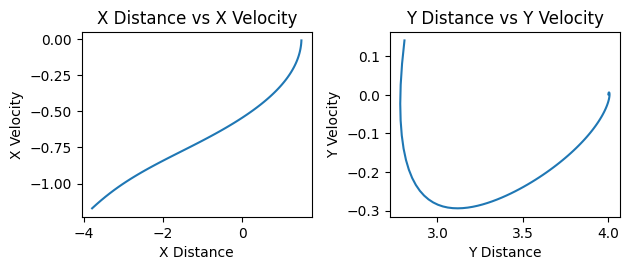

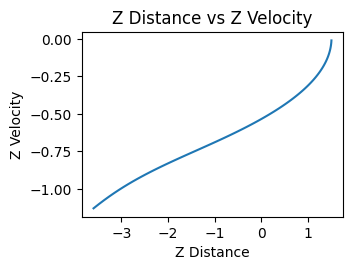

_______________________________________________________________________________________________________________

Iteration number:	 20
loss: 27.914


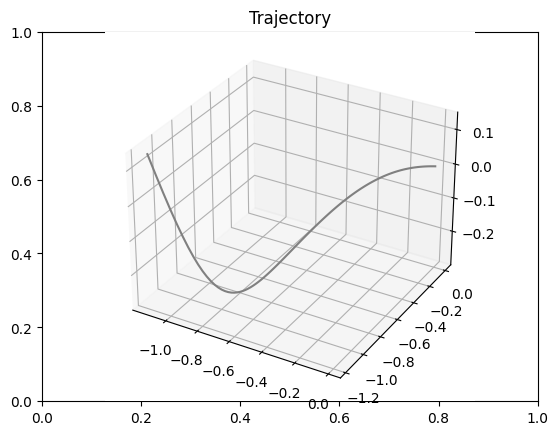

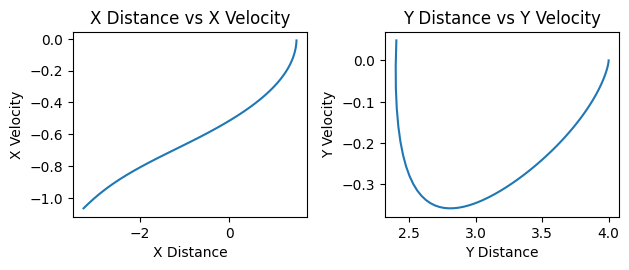

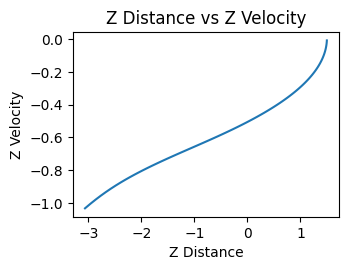

_______________________________________________________________________________________________________________

Iteration number:	 21
loss: 20.397


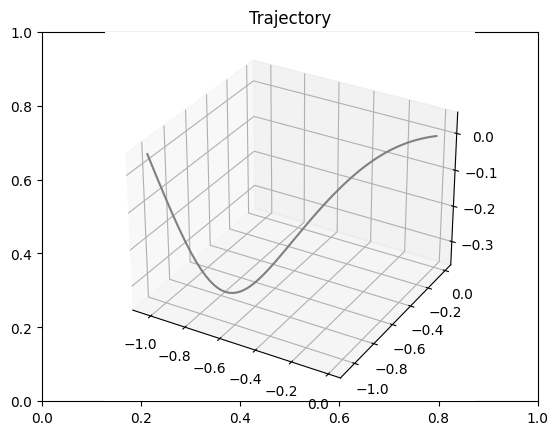

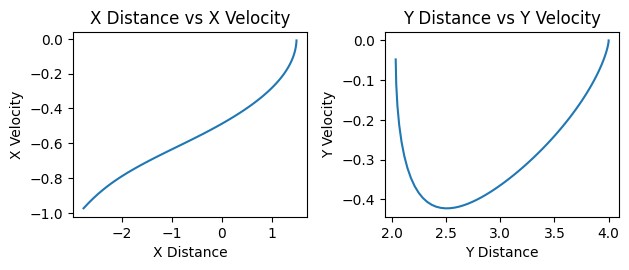

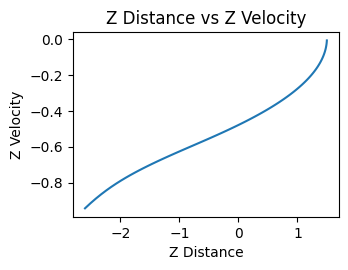

_______________________________________________________________________________________________________________

Iteration number:	 22
loss: 14.716


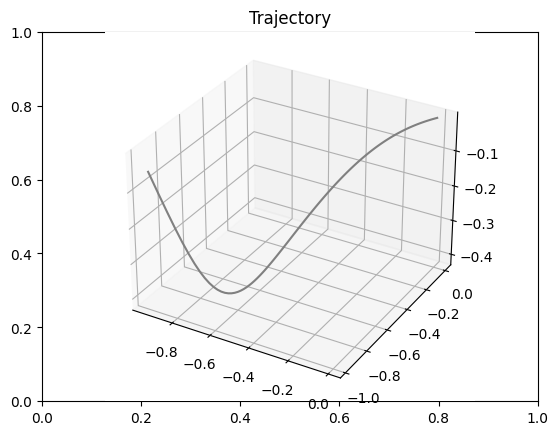

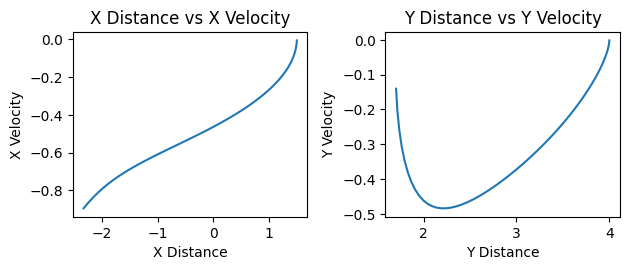

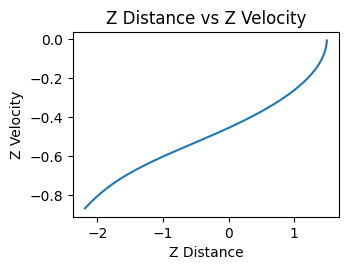

_______________________________________________________________________________________________________________

Iteration number:	 23
loss: 10.350


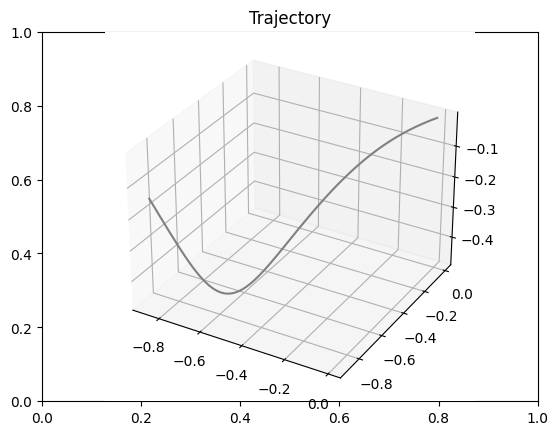

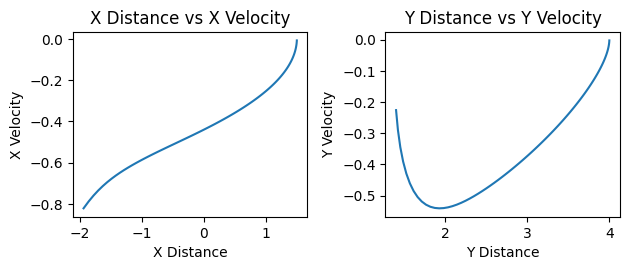

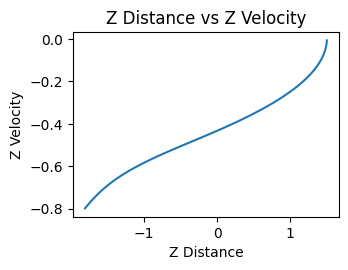

_______________________________________________________________________________________________________________

Iteration number:	 24
loss: 7.320


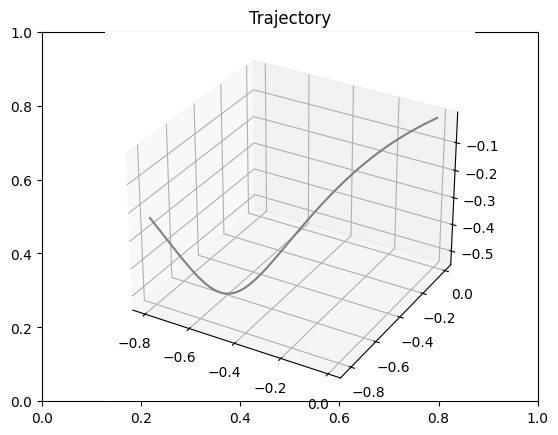

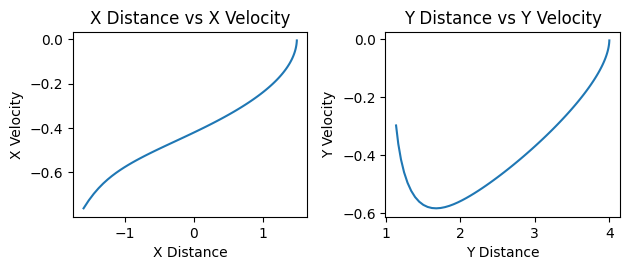

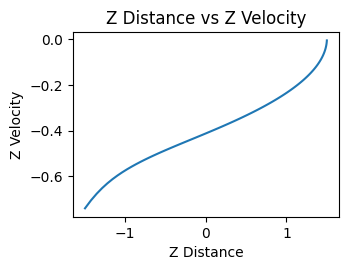

_______________________________________________________________________________________________________________

Iteration number:	 25
loss: 5.334


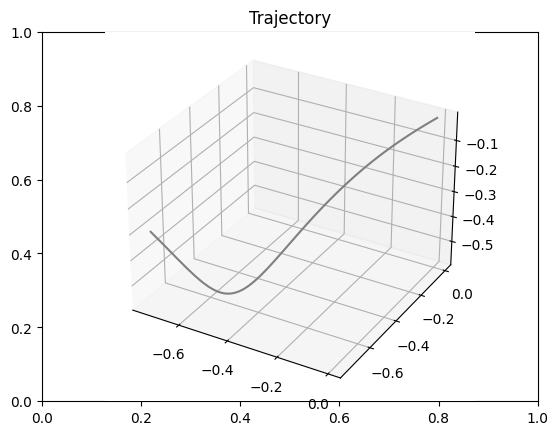

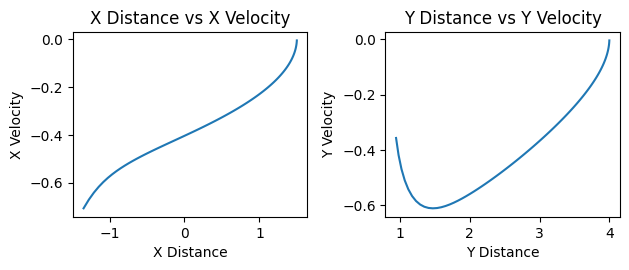

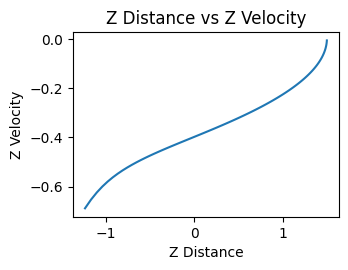

_______________________________________________________________________________________________________________

Iteration number:	 26
loss: 3.963


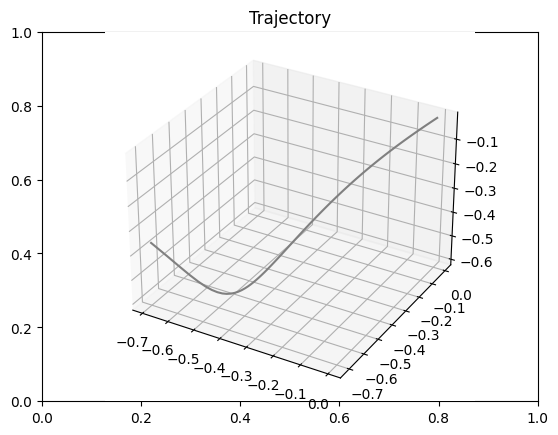

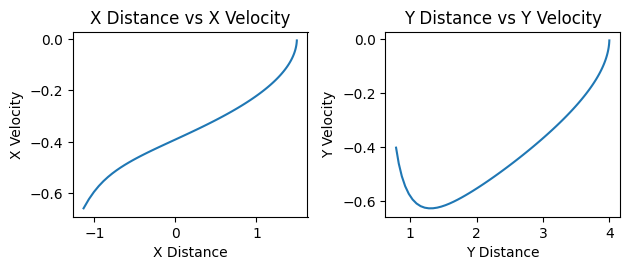

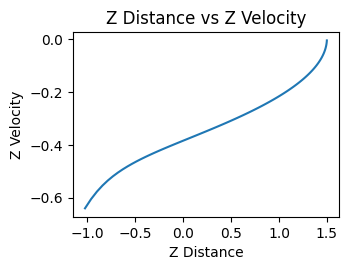

_______________________________________________________________________________________________________________

Iteration number:	 27
loss: 2.988


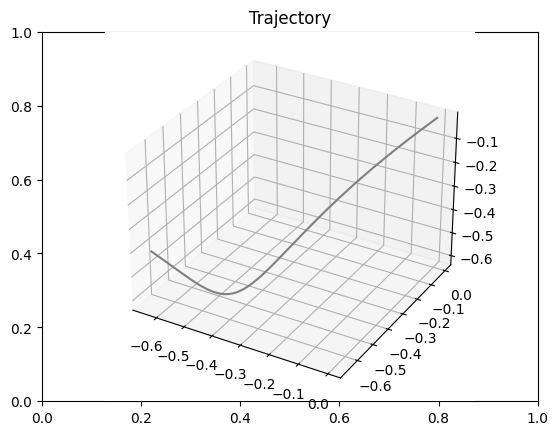

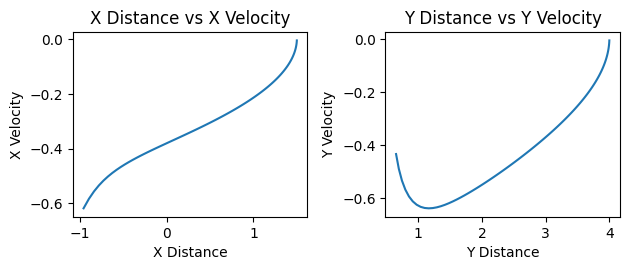

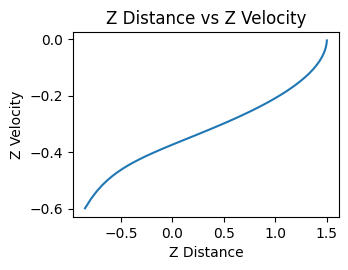

_______________________________________________________________________________________________________________

Iteration number:	 28
loss: 2.289


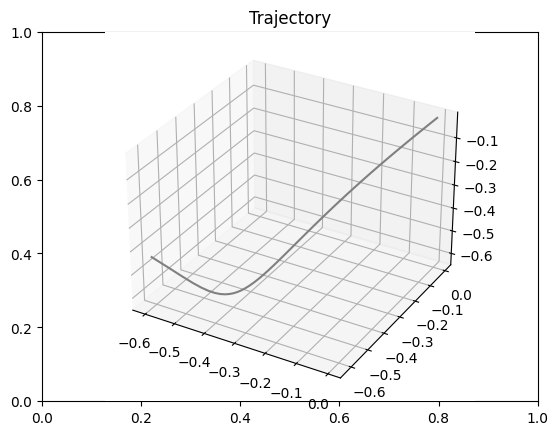

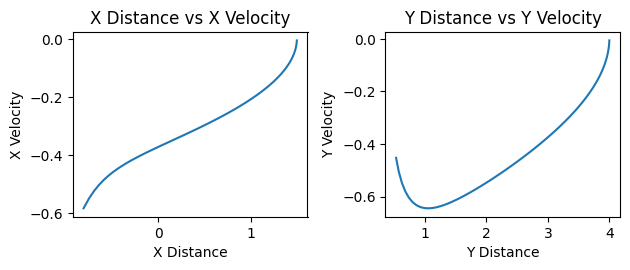

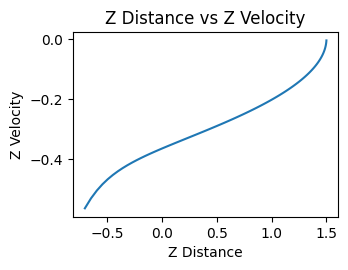

_______________________________________________________________________________________________________________

Iteration number:	 29
loss: 1.781


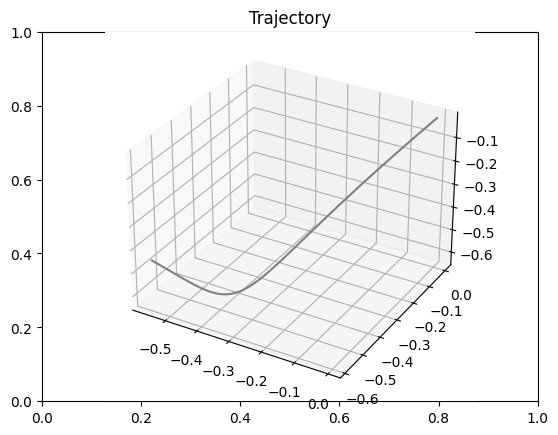

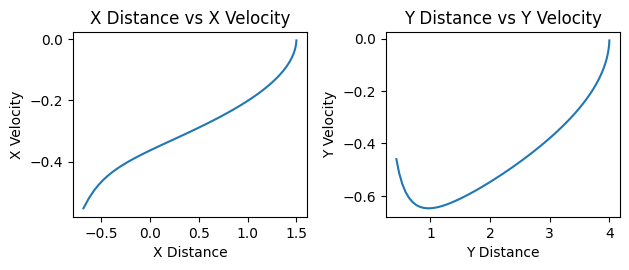

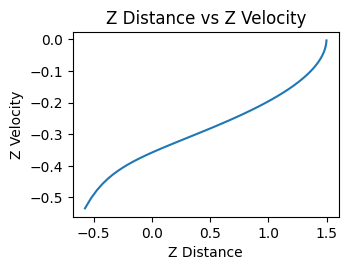

_______________________________________________________________________________________________________________

Iteration number:	 30
loss: 1.416


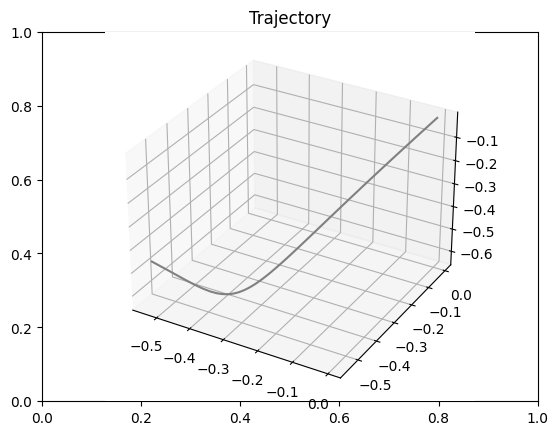

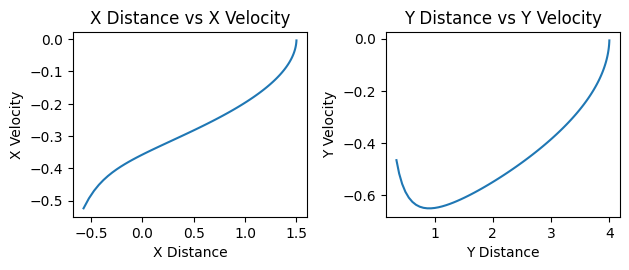

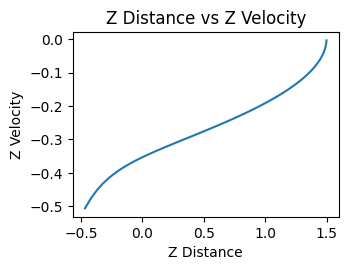

_______________________________________________________________________________________________________________

Iteration number:	 31
loss: 1.153


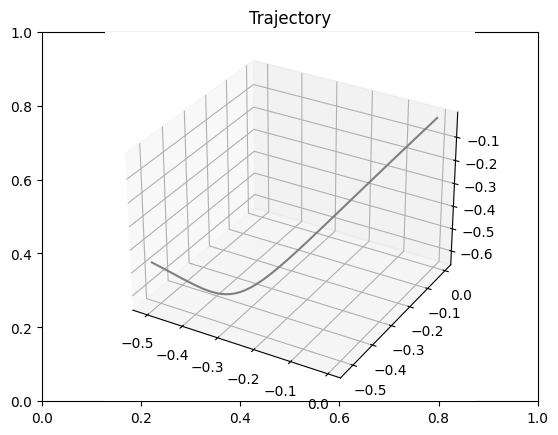

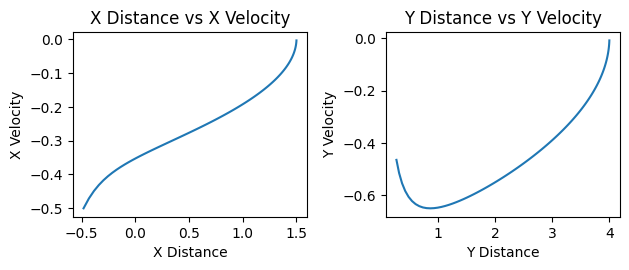

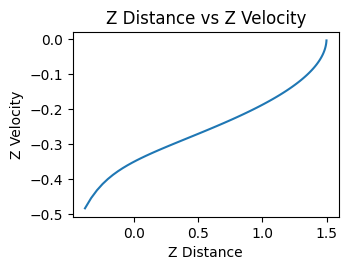

_______________________________________________________________________________________________________________

Iteration number:	 32
loss: 0.953


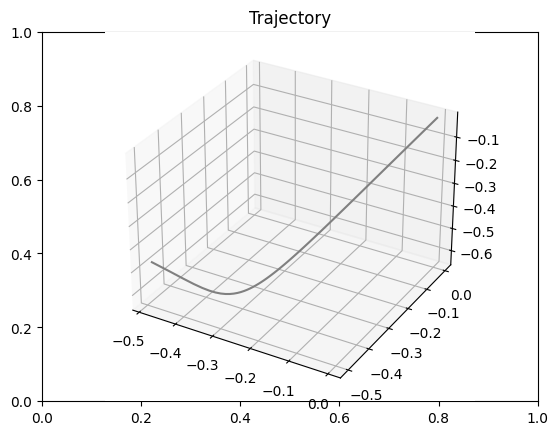

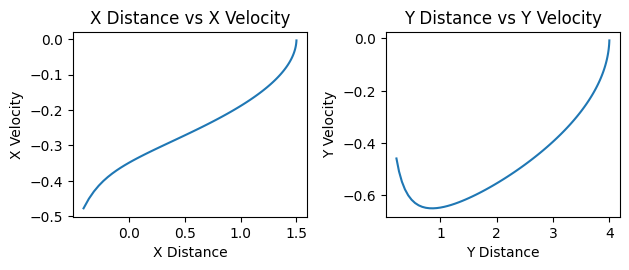

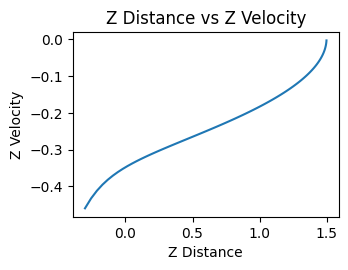

_______________________________________________________________________________________________________________

Iteration number:	 33
loss: 0.792


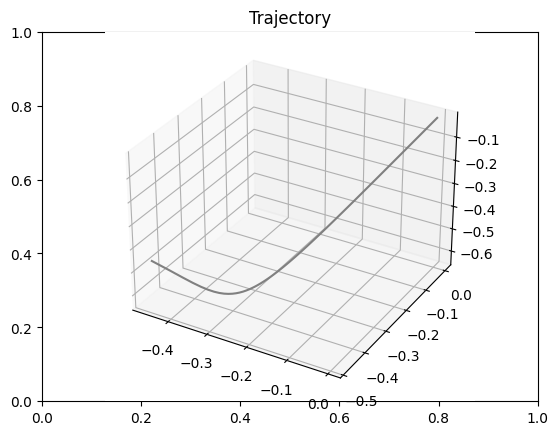

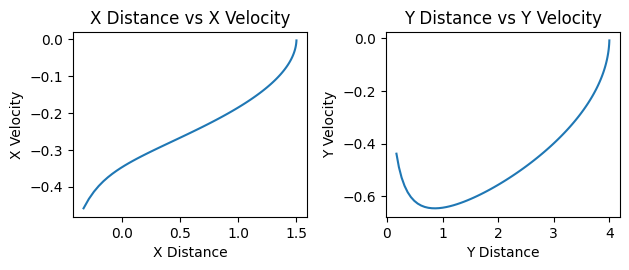

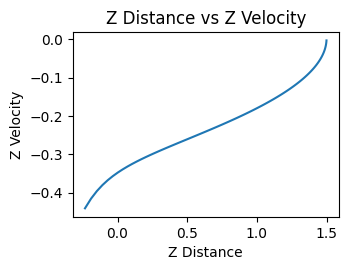

_______________________________________________________________________________________________________________

Iteration number:	 34
loss: 0.659


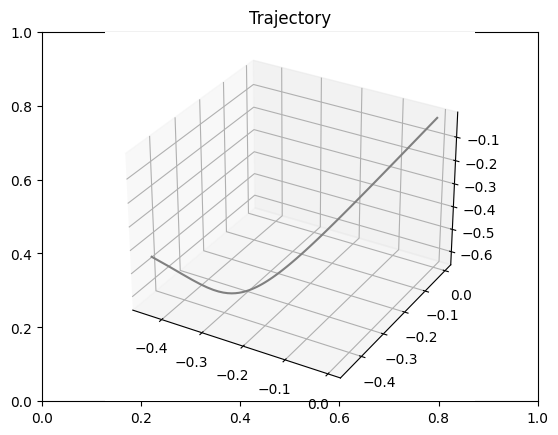

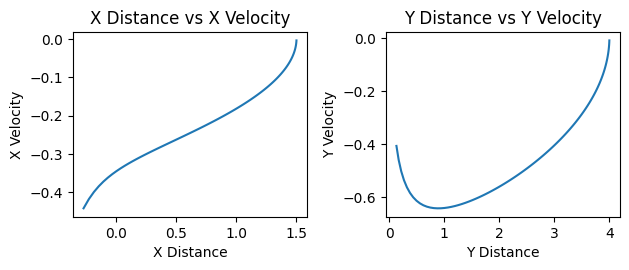

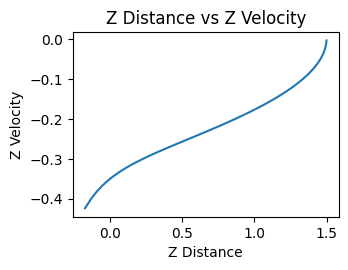

_______________________________________________________________________________________________________________

Iteration number:	 35
loss: 0.546


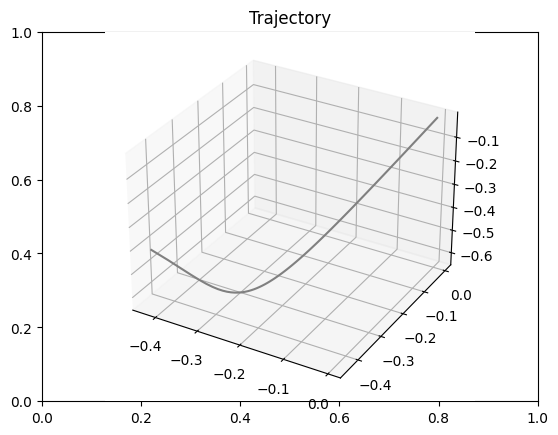

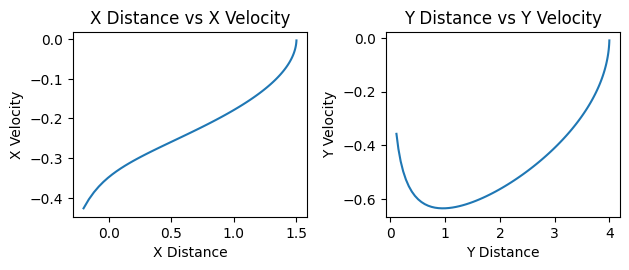

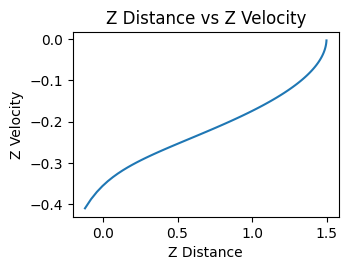

_______________________________________________________________________________________________________________

Iteration number:	 36
loss: 0.456


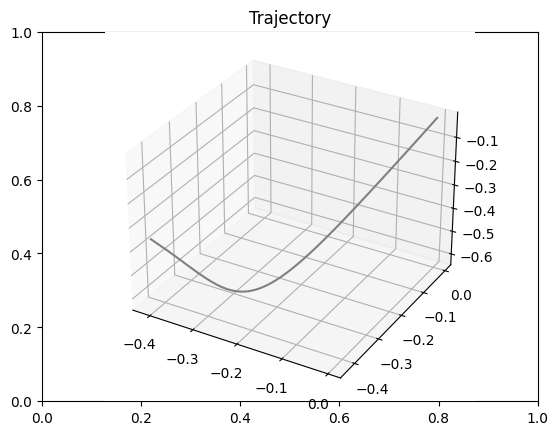

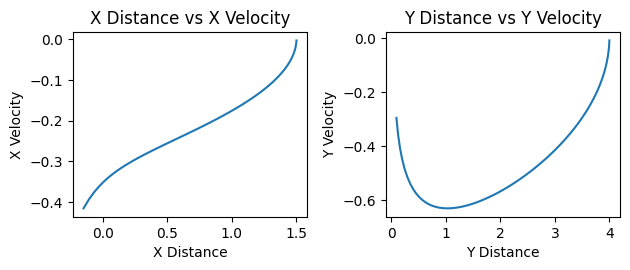

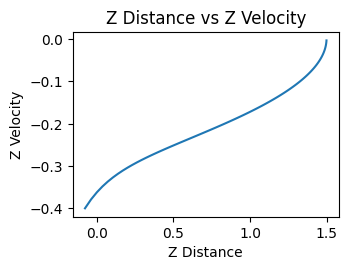

_______________________________________________________________________________________________________________

Iteration number:	 37
loss: 0.394


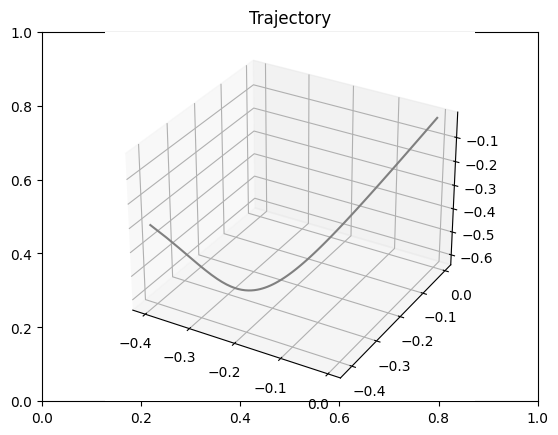

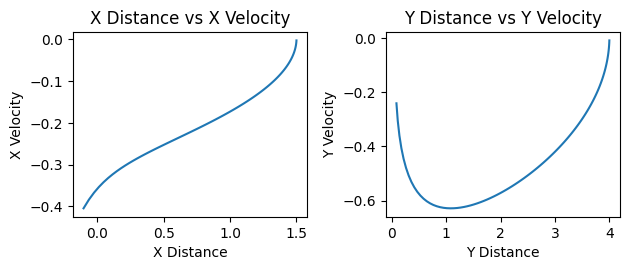

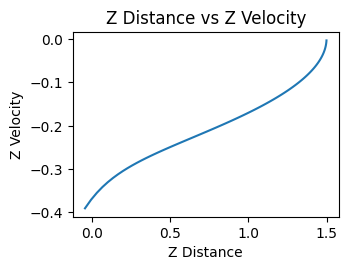

_______________________________________________________________________________________________________________

Iteration number:	 38
loss: 0.352


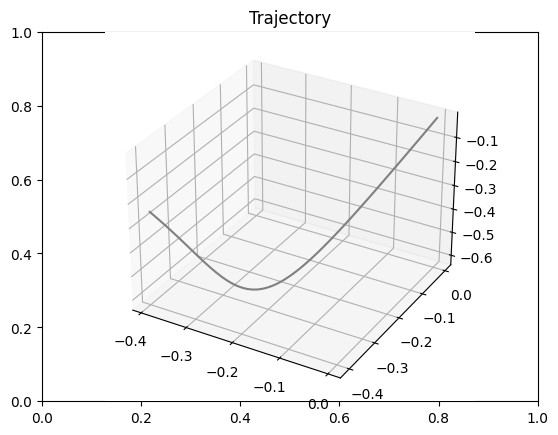

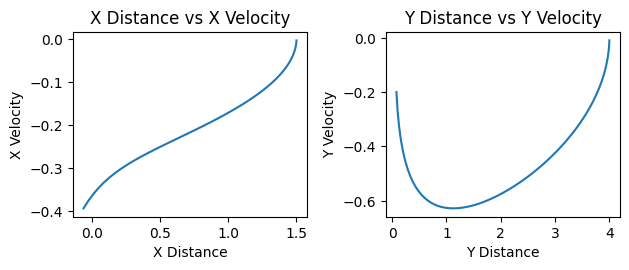

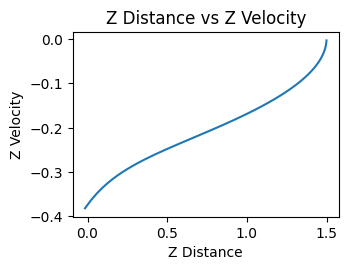

_______________________________________________________________________________________________________________

Iteration number:	 39
loss: 0.322


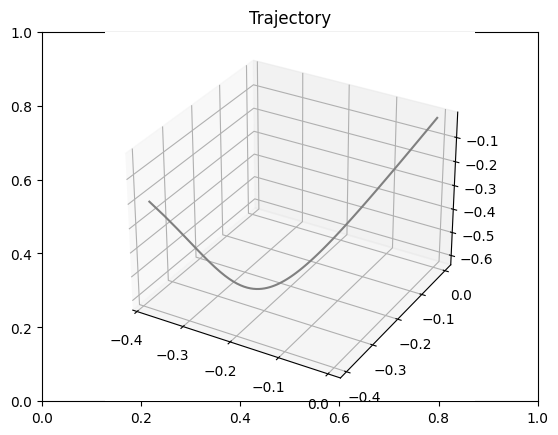

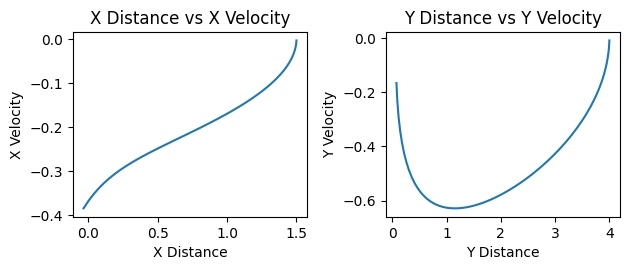

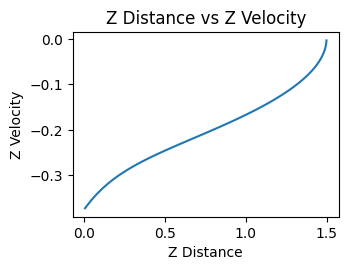

_______________________________________________________________________________________________________________

Iteration number:	 40
loss: 0.300


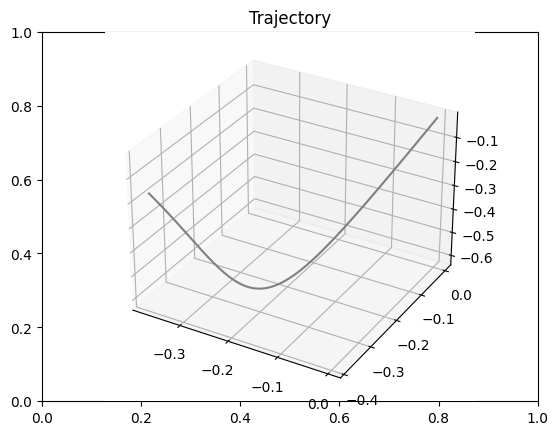

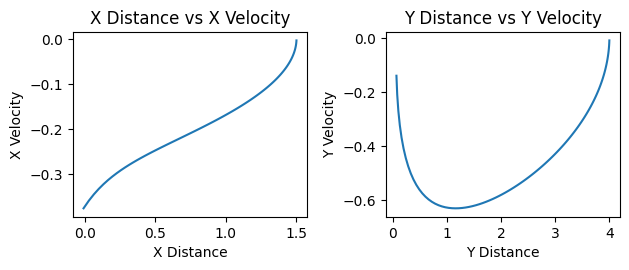

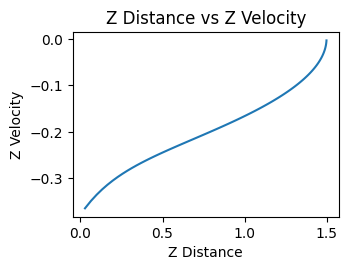

_______________________________________________________________________________________________________________

Iteration number:	 41
loss: 0.283


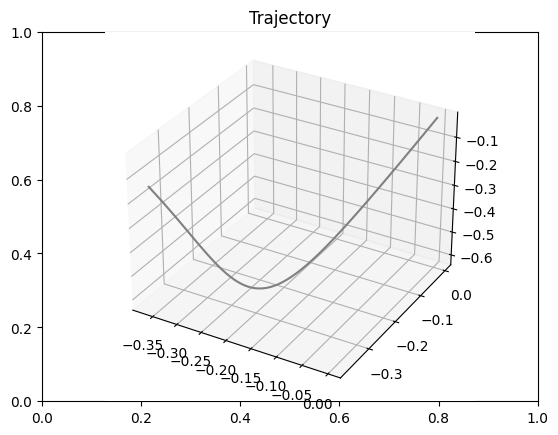

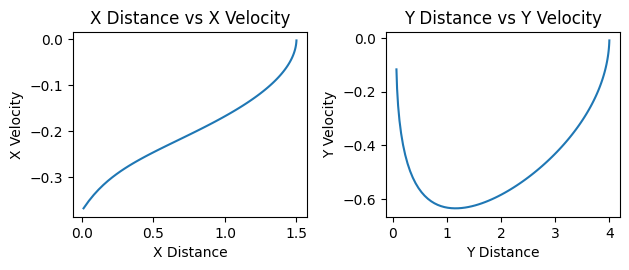

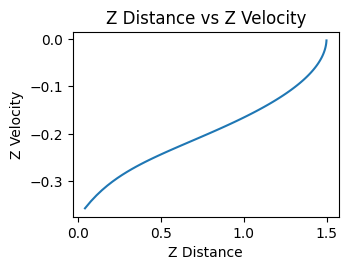

_______________________________________________________________________________________________________________

Iteration number:	 42
loss: 0.268


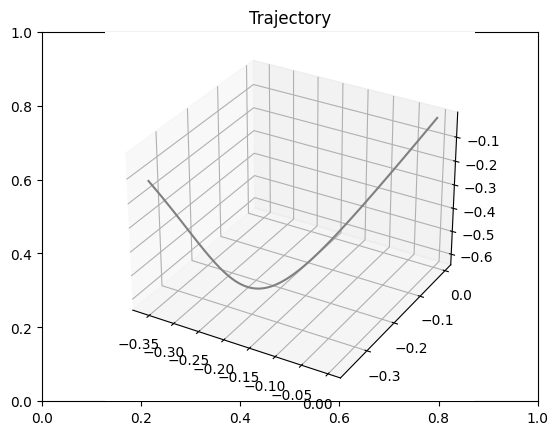

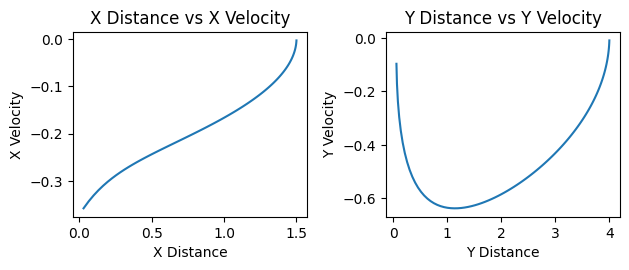

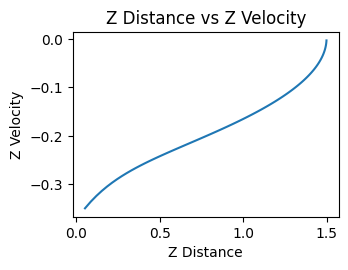

_______________________________________________________________________________________________________________

Iteration number:	 43
loss: 0.255


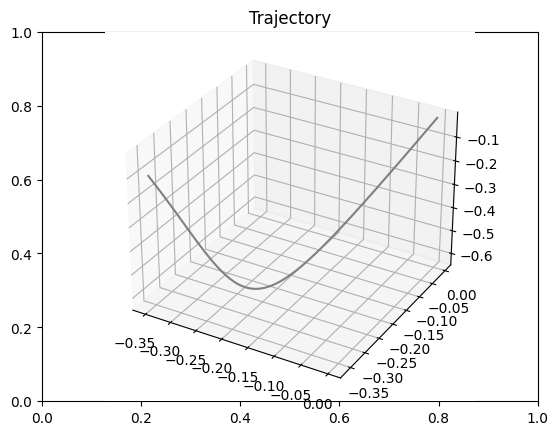

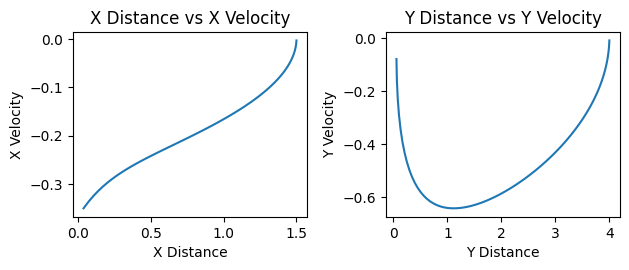

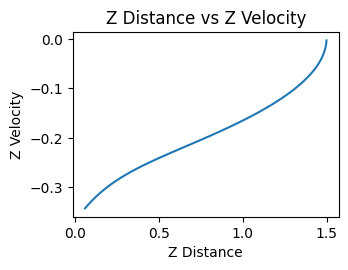

_______________________________________________________________________________________________________________

Iteration number:	 44
loss: 0.244


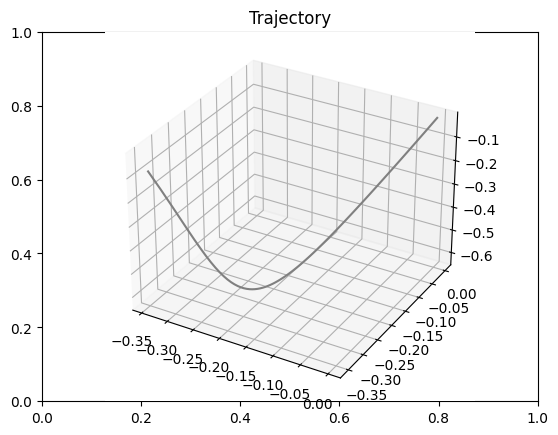

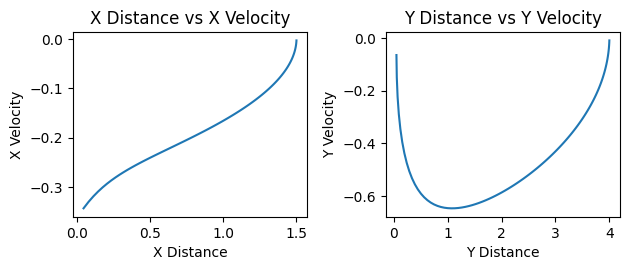

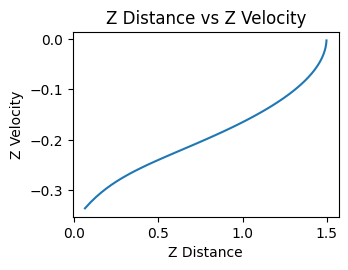

_______________________________________________________________________________________________________________

Iteration number:	 45
loss: 0.234


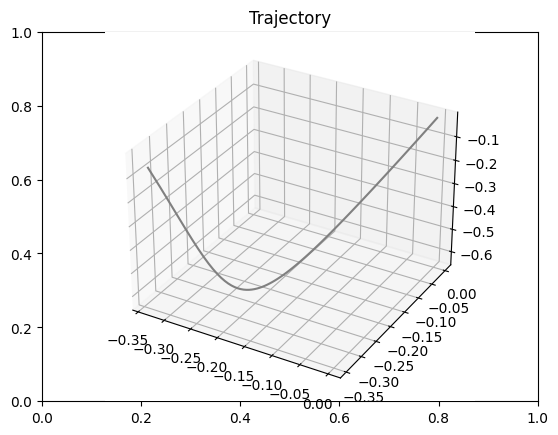

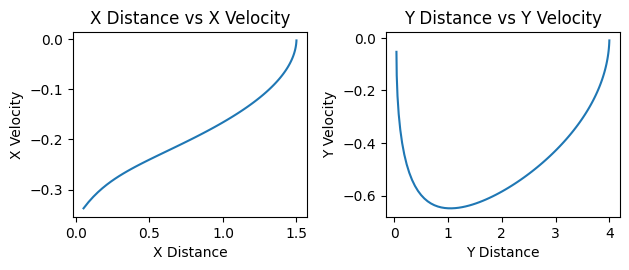

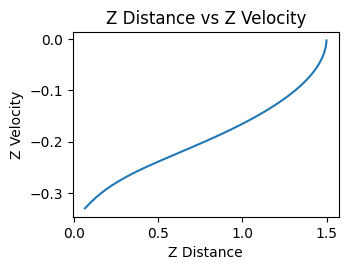

_______________________________________________________________________________________________________________

Iteration number:	 46
loss: 0.226


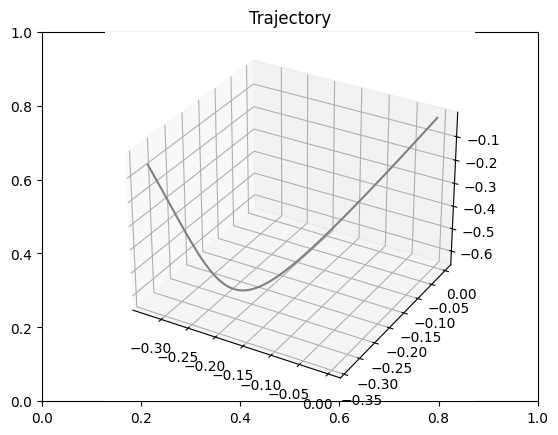

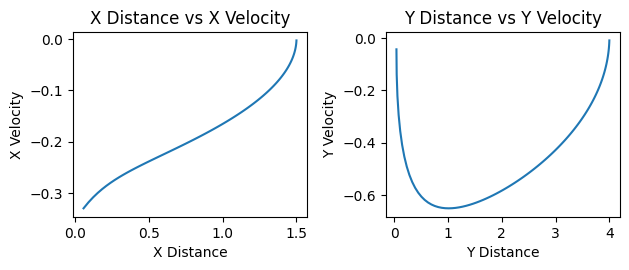

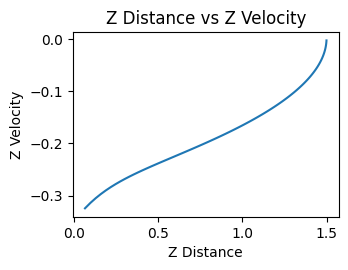

_______________________________________________________________________________________________________________

Iteration number:	 47
loss: 0.217


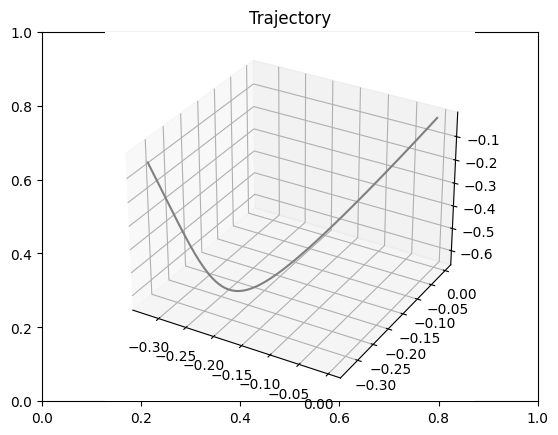

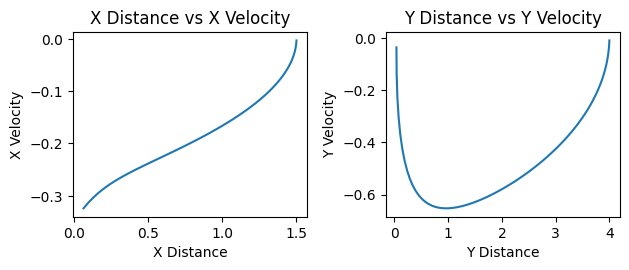

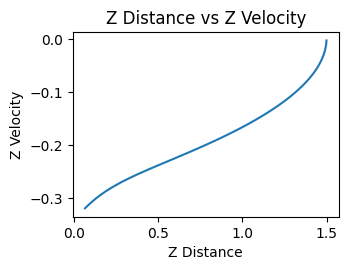

_______________________________________________________________________________________________________________

Iteration number:	 48
loss: 0.210


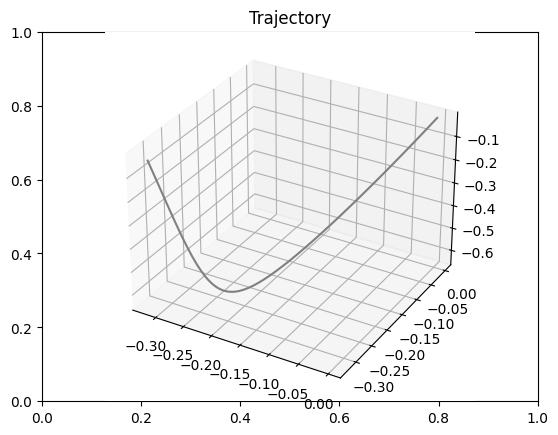

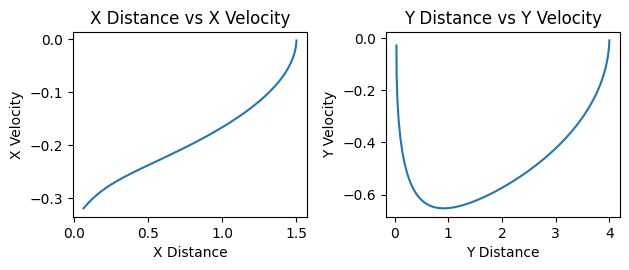

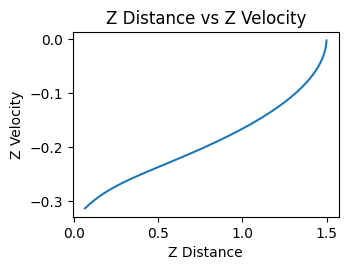

_______________________________________________________________________________________________________________

Iteration number:	 49
loss: 0.204


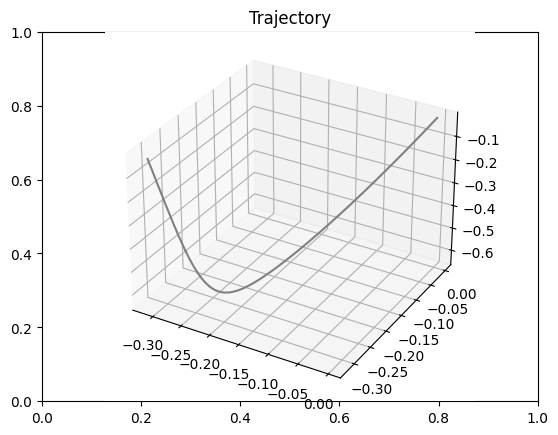

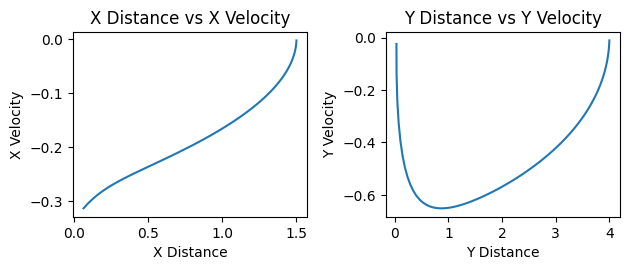

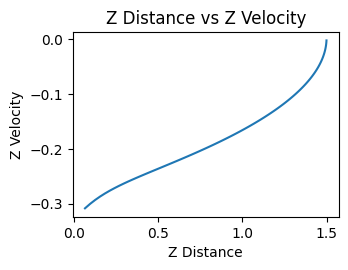

_______________________________________________________________________________________________________________

Iteration number:	 50
loss: 0.199


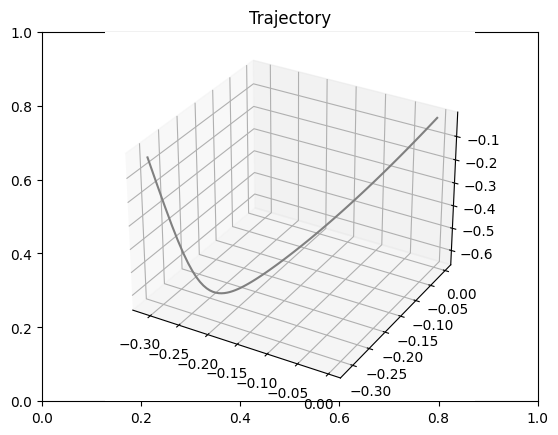

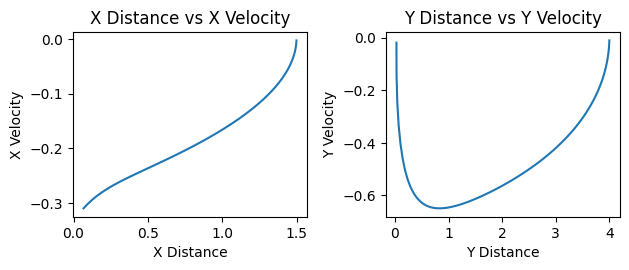

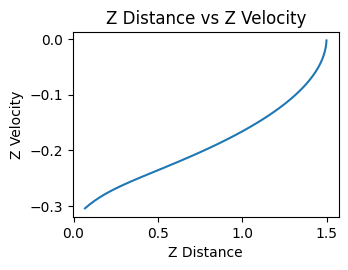

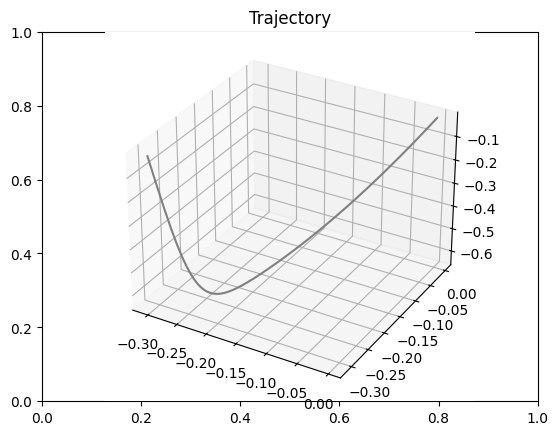

In [4]:
#Run the code

T = 100  # number of time steps
dim_input = 6  # state space dimensions (x, x_dot, y, y_dot, z, z_dot)
dim_hidden = 12  # latent dimensions
dim_output = 3  # action space dimensions (a_x, a_y, a_z)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # solve the optimization problem

## 3. Analysis of the results

For the 3 Dimensional case where drag was considered in all 3 direction x,y & z. the loss is very high in the start but decreases significantly as iterations progress but the solution does not converge even after 60 iteration as loss is not equal to zero but according to the plotted graphs it is evident that the rocket is landing right on the platform.